In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd 

def get_promoters(number_neutral_bases):
    number_neutral_bases_lower, number_neutral_bases_upper = tuple(map(int, number_neutral_bases.split(',')))
    CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'
    promoters_filename = (
        f'{CONSTRAINT_TOOLS_DATA}/promoters/grch38/'
        f'promoters-with-zscores.{number_neutral_bases_lower}-{number_neutral_bases_upper}.bed'
    )
    df = pd.read_csv(promoters_filename, sep='\t')
    
    # filter NaN
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    df = df[row_has_NaN == False]
    
    return df

# frames = [get_promoters(number_neutral_bases) for number_neutral_bases in [
#     "150,200",
#     "200,250",
#     "250,300", 
#     "300,400",
#     "400,500",
#     "500,600",
#     "600,750",
#     "750,1000",
# ]]
# promoters = pd.concat(frames, ignore_index=True)

promoters = get_promoters("500,600")

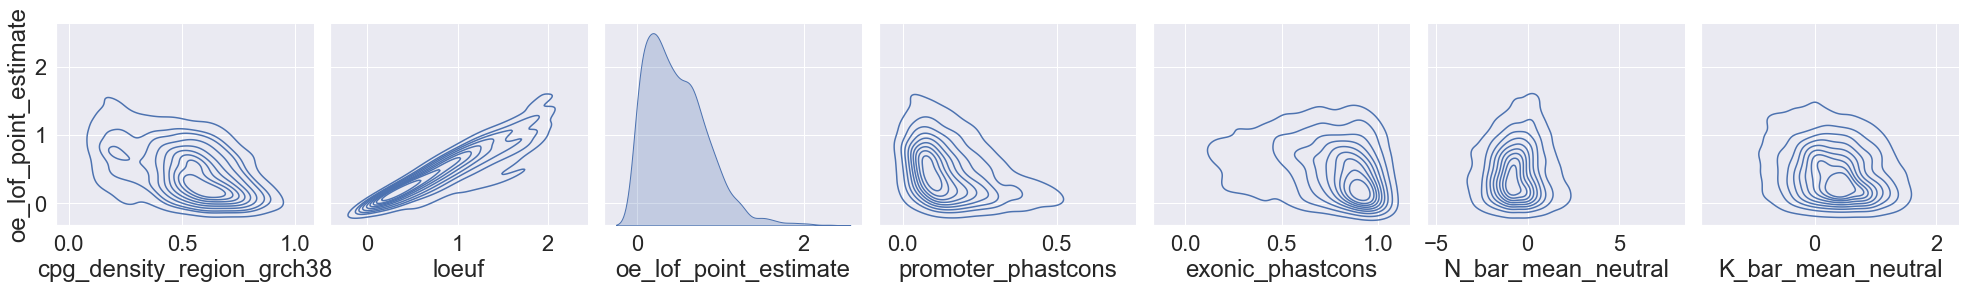

In [3]:
import seaborn as sns
sns.set(font_scale = 2)

x_vars = [
    'cpg_density_region_grch38', 
    'loeuf', 
    'oe_lof_point_estimate', 
    'promoter_phastcons', 
    'exonic_phastcons', 
    'N_bar_mean_neutral', 
    'K_bar_mean_neutral'
]

sns.pairplot(
    data=promoters,
    x_vars=x_vars,
    y_vars=['oe_lof_point_estimate'],
    kind='kde',
    height=4
)

In [4]:
# "Following previous work,39 we classified genes with LOEUF < 0.35 as highly LoF intolerant."
# https://www.sciencedirect.com/science/article/pii/S0002929720302445?via%3Dihub
# https://ars.els-cdn.com/content/image/1-s2.0-S0002929720302445-mmc1.pdf

promoters['LoF_intolerant'] = promoters['loeuf'] < 0.35
# promoters['LoF_intolerant'] = promoters['oe_lof_point_estimate'] < 0.35

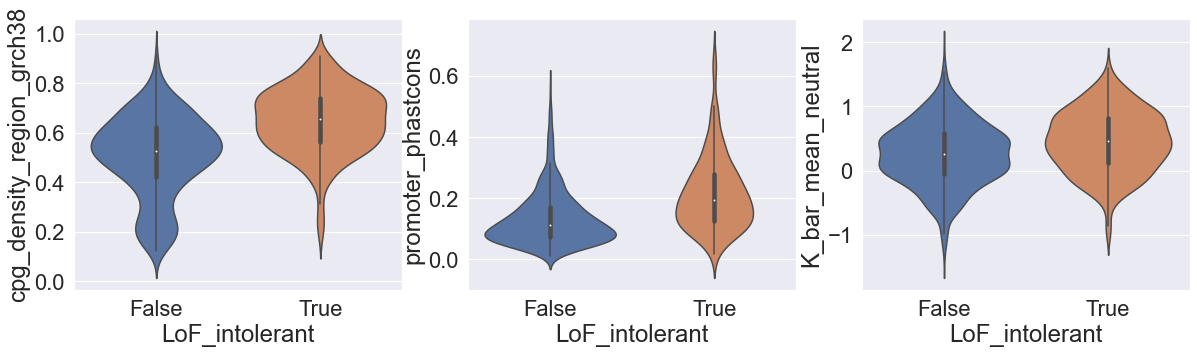

In [5]:
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i, y in enumerate(['cpg_density_region_grch38', 'promoter_phastcons', 'K_bar_mean_neutral']):
    sns.violinplot(
        data=promoters, 
        y=y, 
        x="LoF_intolerant",
        ax=axs[i]
    )

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# logistic regression: 
# "settled on training a logistic regression model with CpG density, and promoter/exonic conservation as three linear predictors."
# https://github.com/hansenlab/lof_prediction_paper_repro/blob/ebc7d30c01def485cc0f9e62457904a4b86409ca/predLoF_CpG_training_and_assessment.R#L12

# https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
pipe = make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced"))


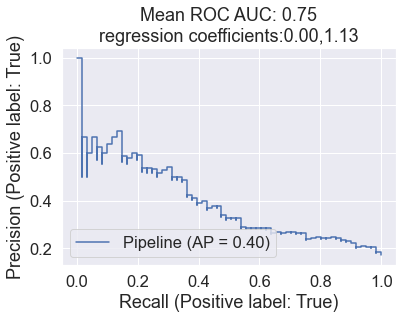

In [7]:
def compute_metrics(predictors): 
    X = promoters[predictors]

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=1)
    X = poly.fit_transform(X)

    y = promoters['LoF_intolerant']

    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.model_selection import cross_val_score
    import numpy as np 

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=None)
    # n_jobs = -1 means using all processors: 
    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    title_line_1 = 'Mean ROC AUC: %.2f' % np.mean(scores)

    from sklearn.metrics import PrecisionRecallDisplay
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    pipe.fit(X_train, y_train)
    precision_recall_display = PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test)
    
    regression_coefficients, = pipe.get_params()['logisticregression'].coef_
    regression_coefficients = ['%.2f' % regression_coefficient for regression_coefficient in regression_coefficients]
    title_line_2 = 'regression coefficients:' +  ','.join(regression_coefficients)

    ax = precision_recall_display.ax_
    ax.set_title(title_line_1 + '\n' + title_line_2)
    
sns.set(font_scale = 1.5)    
compute_metrics(predictors=[
    'cpg_density_region_grch38'
])

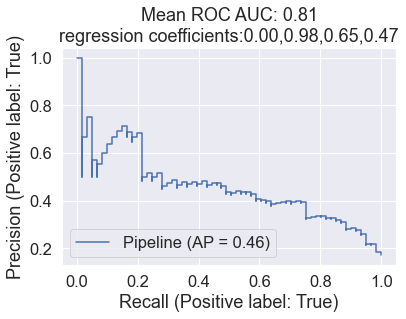

In [8]:
compute_metrics(predictors=[
    'cpg_density_region_grch38', 
    'promoter_phastcons', 
    'exonic_phastcons'
])

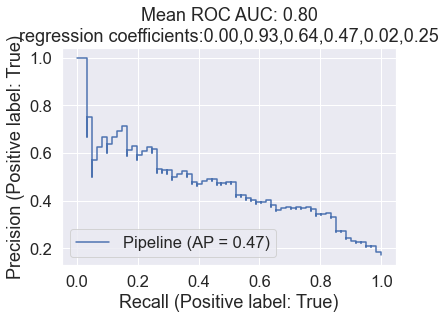

In [9]:
compute_metrics(predictors=[
    'cpg_density_region_grch38', 
    'promoter_phastcons', 
    'exonic_phastcons', 
    'N_bar_mean_neutral', 
    'K_bar_mean_neutral'
])